In [1]:
%matplotlib inline

In [2]:
import numpy
import scipy.optimize
import matplotlib.pyplot
import ipywidgets
import IPython

In [3]:
NUM_NODES = [ 512,  800, 1200, 1600, 1800 ]
MEASURED_TFLOPS = numpy.array([163, 243, 364, 491, 561]) * 1000

# FP64 performance - from https://www.nvidia.com/en-us/data-center/h100/
HGX_H100_RPEAK_VECTOR_TFLOPS = 8 * 34
HGX_H100_RMAX_TFLOPS = 8 * 45
HGX_H100_RPEAK_TENSOR_TFLOPS = 8 * 67

# from https://www.techpowerup.com/320542/unwrapping-the-nvidia-b200-and-gb200-ai-gpu-announcements#g320542-9
GB200_RPEAK_TENSOR_TFLOPS = 90

In [4]:
# Define the Gustafson's law function for fitting
def gustafson_tflops(x, s, y1):
    """
    Calculate the performance in TFLOPS for a given number of nodes using Gustafson's law.

    Args:
        x (int): number of nodes
        s (float): serial fraction
        y1 (float): performance of a single node, in TFLOPS

    Returns:
        float: performance in TFLOPS for the given number of nodes
    """
    return y1 * (s + (1 - s) * x)

Serial fraction (s): 3.036826363447845e-12
y(x=1): 308.27949001399514 (38.53 per GPU)


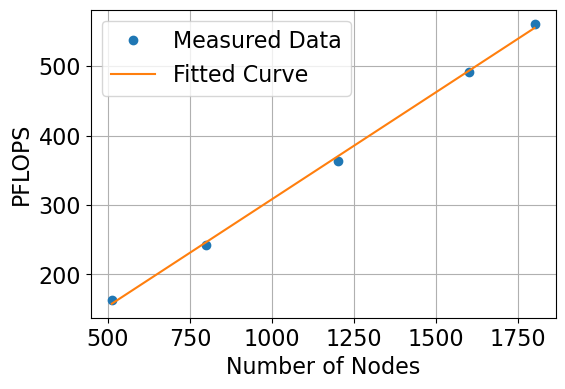

In [5]:
# Perform curve fitting with constraints. You can change the serial fraction
# quite dramatically and still get a good fit, so you don't really need to
# measure y1 in advance.
bounds = (
    [
        0.00, # serial fraction minimum bound (never less than 0.05)
        8 * 34.0 # tflops per node minimum bound (never less than 0.0)
    ],
    [
        1.00, # serial fraction maximum bound (never greater than 1.0)
        8 * 67.0 # numpy.inf # tflops per node maximum bound (no upper limit)
    ]
)
params, _ = scipy.optimize.curve_fit(gustafson_tflops, NUM_NODES, MEASURED_TFLOPS, bounds=bounds)

# Extract the coefficients
s, y1 = params

# Print the results
print(f"Serial fraction (s): {s}")
print(f"y(x=1): {y1} ({y1/8:.2f} per GPU)")

# Plot the original data and the fitted curve
fig, ax = matplotlib.pyplot.subplots()
ax.plot(NUM_NODES, MEASURED_TFLOPS / 1000, 'o', label='Measured Data')
ax.plot(NUM_NODES, gustafson_tflops(numpy.array(NUM_NODES) / 1000, *params), '-', label='Fitted Curve')
ax.set_xlabel('Number of Nodes')
ax.set_ylabel('PFLOPS')
ax.legend()
ax.grid(True)

In [6]:
# make some ipython widgets that let me select a num_nodes and then return the predicted TFLOPS

num_nodes_widget = ipywidgets.IntText(value=1800, description='Number of Nodes', step=128)
out = ipywidgets.Output()
out.clear_output()
with out:
    print(f"Predicted PFlops for 1800 nodes: {gustafson_tflops(1800, *params)/1e3:.2f}")

# draw input and output widgets in a vertical box
widget_container = ipywidgets.VBox([num_nodes_widget, out])

IPython.display.display(widget_container)

def on_value_change(change):
    num_nodes = change['new']
    predicted_tflops = gustafson_tflops(num_nodes, *params)
    out.clear_output()
    with out:
        print(f"Predicted PFlops for {num_nodes} nodes: {predicted_tflops/1e3:.2f}")

num_nodes_widget.observe(on_value_change, names='value')

In [7]:
# make some ipython widgets that let me select a num_nodes and then return the predicted TFLOPS

GB200_PARAMS = (
    params[0],
    params[1] / HGX_H100_RPEAK_TENSOR_TFLOPS * GB200_RPEAK_TENSOR_TFLOPS,
)
print(f"Serial fraction (s): {GB200_PARAMS[0]}")
print(f"y(x=1): {GB200_PARAMS[1]} ({GB200_PARAMS[1]/2:.2f} per GPU)")

num_nodes_widget_gb200 = ipywidgets.IntText(value=1800, description='Number of Nodes', step=128)
out_gb200 = ipywidgets.Output()
out_gb200.clear_output()
with out_gb200:
    print(f"Predicted PFlops for 1800 nodes: {gustafson_tflops(1800, *GB200_PARAMS)/1e3:.2f}")

# draw input and output widgets in a vertical box
widget_container_gb200 = ipywidgets.VBox([num_nodes_widget_gb200, out_gb200])

IPython.display.display(widget_container_gb200)

def on_value_change(change):
    num_nodes = change['new']
    predicted_tflops = gustafson_tflops(num_nodes, *GB200_PARAMS)
    out_gb200.clear_output()
    with out_gb200:
        print(f"Predicted PFlops for {num_nodes} nodes: {predicted_tflops/1e3:.2f}")

num_nodes_widget_gb200.observe(on_value_change, names='value')

Serial fraction (s): 3.036826363447845e-12
y(x=1): 51.76334720384247 (25.88 per GPU)
